In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu

In [3]:
exp_str = 'AH007_2022-03-28_2-4-5'

In [4]:
# Create the job
job = Job('/mnt/md0/runs',exp_str, create=False, overwrite=False, verbosity = 3)

   Found and loaded params from /mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/params.npy


In [5]:
combined_dir = job.dirs['detection-combined-full']

In [6]:
outputs = ui.load_outputs(combined_dir, load_traces=True)

In [7]:
v1, v2 = ui.make_label_vols(outputs['stats'], outputs['vmap'].shape, 
            iscell =  outputs['iscell_curated_slider'], 
                  cmap='Blues', lam_max = 0.3)

In [8]:
stats = outputs['stats']
shape = outputs['vmap'].shape
iscell = outputs['iscell_curated_slider']
lam_thresh = 0.15
coords = [stat['coords'] for stat in stats]
lams = [stat['lam'] for stat in stats]
F = outputs['F']

In [9]:
import copy

In [24]:
meds = n.array([stat['med'] for stat in stats])

In [11]:
spks = outputs['spks']

In [12]:
sm = spks.mean(axis=0)

(2000.0, 2100.0)

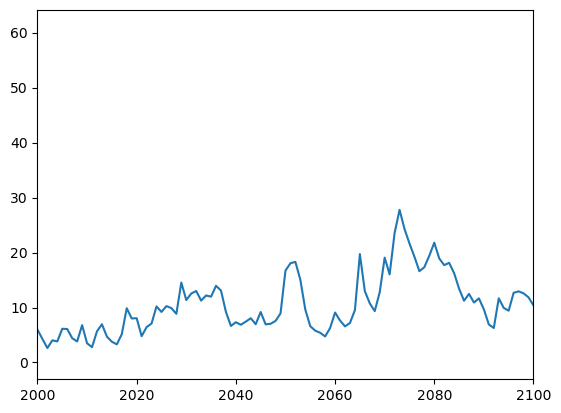

In [14]:
plt.plot(sm)
plt.xlim(2000,2100)

In [50]:
cell_act_vol = n.zeros( (nts,) + shape)

In [51]:
nts = 50
start_idx = 2040

In [54]:
cell_act_vol[:, cz,cy,cx].shape

(50, 11)

In [57]:
F[i, start_idx:start_idx+nts].shape

(50,)

In [79]:
Fm = F.mean(axis=1, keepdims=True)
Fstd = F.std(axis=1, keepdims=True)

In [98]:
spks_m = spks.mean(axis=1, keepdims=True)
spks_std = spks.std(axis=1, keepdims=True)

In [88]:
! mkdir /mnt/md0/share/series_z

In [92]:

from scipy.ndimage import gaussian_filter1d
# from scipy.signal import gaussian_filter1d

In [93]:
def filt(signal, width = 3, axis=0, mode='gaussian'):
    if width == 0:
        return signal

    if mode == 'gaussian':
        out = gaussian_filter1d(signal, sigma=width, axis=axis)
    else:
        assert False, "mode not implemented"
    return out

In [115]:
spks_z = (spks - spks.mean(axis=1,keepdims=True))/spks.std(axis=1,keepdims=True)

In [125]:
spks_f = filt(spks_z, width=3, axis=1)

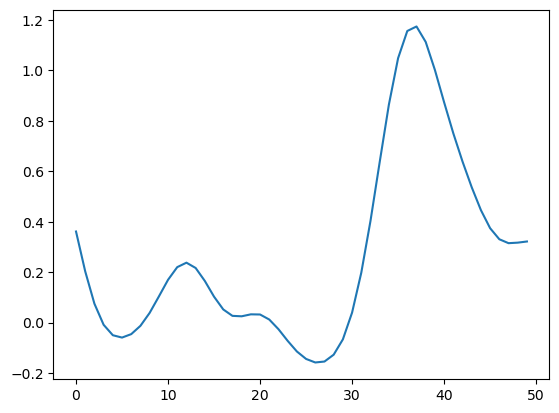

In [126]:
plt.plot(spks_f[100, start_idx:start_idx+nts])

In [127]:
for i in range(len(stats)):
    if iscell[i,0]:
        cz,cy,cx = coords[i]
        if meds[i][0] == 0:
            continue
        lam = copy.copy(lams[i])
        idxs = lam > lam_thresh
        cz = cz[idxs]; cy = cy[idxs]; cx = cx[idxs]
        for j in range(len(cz)):
            cell_act_vol[:,cz[j], cy[j],cx[j]] =  spks_f[i, start_idx:start_idx+nts]

In [128]:
cell_act_vol.max()

6.034681797027588

In [129]:
cell_act_vol_int = (1000*cell_act_vol).astype(n.int16)

In [130]:
for i in range(nts):
    tfu.save_mrc('/mnt/md0/share/series_spks_f3z', '%03d.mrc' % i,cell_act_vol_int[i], voxel_size=(4,4,15), dtype=n.int16)

In [63]:
tfu.save_mrc('/mnt/md0/share', 'cell_activity.mrc',cell_act_vol_int, voxel_size=(4,4,15), dtype=n.int16)

In [67]:
tfu.save_mrc('/mnt/md0/share', 'cell_activity_4d.mrc',cell_act_vol_int, voxel_size=(4,4,15,1), dtype=n.int16)

TypeError: _set_voxel_size() takes 4 positional arguments but 5 were given

In [64]:
cell_act_vol_int.shape

(50, 18, 1000, 850)

In [65]:
50*18

900

In [43]:
cell_vol = n.zeros(shape)

In [44]:
for i in range(len(stats)):
    if iscell[i,0]:
        cz,cy,cx = coords[i]
        if meds[i][0] == 0:
            continue
        lam = copy.copy(lams[i])
        idxs = lam > lam_thresh
        cz = cz[idxs]; cy = cy[idxs]; cx = cx[idxs]
        cell_vol[cz, cy,cx] = 1

In [46]:
tfu.save_mrc('/mnt/md0/share', 'cell_vol.mrc',cell_vol, voxel_size=(4,4,15), dtype=n.int16)